<a href="https://colab.research.google.com/github/therahulparmar/CNN-Model/blob/main/RESNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [4]:
train_path="/content/drive/MyDrive/Pet/Train"
test_path="/content/drive/MyDrive/Pet/Test"
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)

In [5]:
print(class_names)
print(class_names_test)

['train cat', 'train dog']
['test dog', 'test cat']


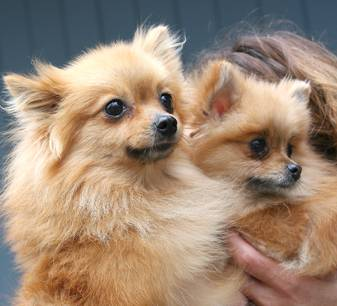

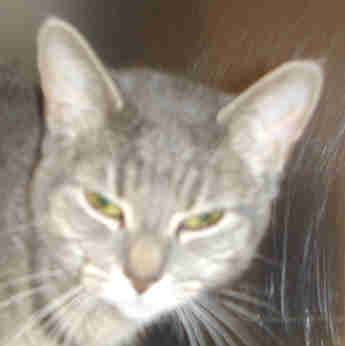

In [6]:
image_dog=cv2.imread("/content/drive/MyDrive/Pet/Test/test dog/dog.77.jpg")
cv2_imshow(image_dog)
image_cat=cv2.imread("/content/drive/MyDrive/Pet/Test/test cat/cat.93.jpg")
cv2_imshow(image_cat)

In [7]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()

In [8]:
train_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/Pet/Train",target_size=(224, 224),batch_size=32,shuffle=True,class_mode='binary')
test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/Pet/Test",target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')

Found 140 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [9]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [10]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [11]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [12]:
base_model = ResNet50(input_shape=(224, 224, 3))

In [13]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [14]:
model = Model(inputs=base_model.input, outputs=headModel)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
______________________________________________________________________________________________

In [16]:
base_model.load_weights("/content/drive/MyDrive/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [17]:
for layer in base_model.layers:
    layer.trainable = False

In [18]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fad0154c890> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fad04dfad10> False
<keras.layers.convolutional.Conv2D object at 0x7fad03ce8690> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7fad03ce8c50> False
<keras.layers.core.Activation object at 0x7fad03ca8a10> False
<keras.layers.pooling.MaxPooling2D object at 0x7fad03ca8850> False
<keras.layers.convolutional.Conv2D object at 0x7fad03c8b590> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7fad03c8bc10> False
<keras.layers.core.Activation object at 0x7fad03c60bd0> False
<keras.layers.convolutional.Conv2D object at 0x7fad03c24510> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7fad03c2c710> False
<keras.layers.core.Activation object at 0x7fad03c1f3d0> False
<keras.layers.convolutional.Conv2D object at 0x7fad03c880d0> False
<keras.layers.convolutional.Conv2D object at 0x7fad03c9fb10> False
<keras.layers.normaliza

In [28]:
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [29]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

In [30]:
mc = ModelCheckpoint('/content/drive/MyDrive/best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [31]:
H = model.fit_generator(train_generator,validation_data=test_generator,epochs=100,verbose=1,callbacks=[es])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
5/5 [==============================] - 60s 10s/step - loss: 0.3095 - accuracy: 0.8866 - val_loss: 0.4096 - val_accuracy: 0.7833
Epoch 2/100
5/5 [==============================] - 34s 7s/step - loss: 0.2731 - accuracy: 0.8942 - val_loss: 0.3696 - val_accuracy: 0.8000
Epoch 3/100
5/5 [==============================] - 34s 7s/step - loss: 0.2370 - accuracy: 0.9382 - val_loss: 0.3397 - val_accuracy: 0.8167
Epoch 4/100
5/5 [==============================] - 35s 8s/step - loss: 0.1591 - accuracy: 0.9486 - val_loss: 0.3049 - val_accuracy: 0.8167
Epoch 5/100
5/5 [==============================] - 34s 7s/step - loss: 0.1892 - accuracy: 0.9157 - val_loss: 0.2836 - val_accuracy: 0.8667
Epoch 6/100
5/5 [==============================] - 34s 8s/step - loss: 0.2083 - accuracy: 0.9278 - val_loss: 0.2526 - val_accuracy: 0.8667
Epoch 7/100
5/5 [==============================] - 34s 7s/step - loss: 0.1413 - accuracy: 0.9649 - val_loss: 0.2353 - val_accuracy: 0.8833
Epoch 8/100
5/5 [=========

In [32]:
model.load_weights("/content/drive/MyDrive/best_model.h5")

In [33]:
model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.22283801436424255, 0.949999988079071]

In [34]:
from keras.models import model_from_json
model_json = model.to_json()
with open("modelresnet.json", "w") as file:
  file.write(model_json)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [35]:
def predict_(image_path):
    #Load the Model from Json File
    json_file = open('/content/modelresnet.json', 'r')
    model_json_c = json_file.read()
    json_file.close()
    model_c = model_from_json(model_json_c)
    #Load the weights
    model_c.load_weights("/content/drive/MyDrive/best_model.h5")
    #Compile the model
    opt = SGD(lr=1e-4, momentum=0.9)
    model_c.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    #load the image you want to classify
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224,224))
    cv2_imshow(image)
    #predict the image
    preds = model_c.predict(np.expand_dims(image, axis=0))[0]
    if preds<= 0.5:
        print("Predicted Label: Cat")
    else:
        print("Predicted Label: Dog")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


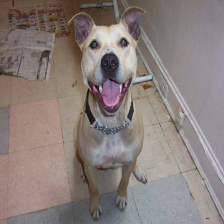

Predicted Label: Dog


In [36]:
predict_("/content/drive/MyDrive/Pet/Test/test dog/dog.83.jpg")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


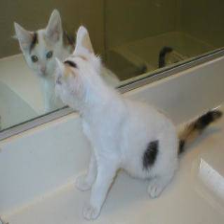

Predicted Label: Cat


In [37]:
predict_("/content/drive/MyDrive/Pet/Test/test cat/cat.80.jpg")